### Wassim Askoul
### 01/27/2019
### Udacity Data Analyst Nanodegree
### Analyze A/B Test Results


### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
#### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this project to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
##### Part I - Probability

To get started, let's import our libraries.

In [90]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [91]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [93]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [94]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [95]:
df.query('group == "treatment" & landing_page == "old_page"').count() + df.query('group == "control" & landing_page == "new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

There is no missing values in our dataset.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Store your new dataframe in **df2**.

In [96]:
df2 = df
df2.drop(df2.query('group == "treatment" & landing_page == "old_page"').index, inplace=True)
df2.drop(df2.query('group == "control" & landing_page == "new_page"').index, inplace=True)

In [97]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [98]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [99]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [100]:
df2.drop(2893, inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Use **df2** in the below cells to answer the quiz questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [101]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [102]:
(df2.query('group == "control" & converted == 1')['user_id'].count()/df2.shape[0])/(df2.query('group == "control"')['user_id'].count()/df2.shape[0])

0.12038630450046119

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [103]:
(df2.query('group == "treatment" & converted == 1')['user_id'].count()/df2.shape[0])/(df2.query('group == "treatment"')['user_id'].count()/df2.shape[0])

0.11880806551510564

d. What is the probability that an individual received the new page?

In [104]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]


0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The probability of conversion for the new page is at 12.04%, while the conversion for the old page is at 11.88%, given that 50% of the individuals recieved the new page. Based on these numbers alone, we could say that the new page has a slight advantage, however, this is one observation only and a practical significance is not present with this information alone. So, an A/B test will be executed below. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, with the following null and alternative hypotheses.  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**$H_{0}$** :   **$p_{old}$** **$>=$** **$p_{new}$**

**$H_{1}$** :   **$p_{old}$** **$<$** **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [105]:
df2['converted'].mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [106]:
df2['converted'].mean()

0.11959708724499628

c. What is $n_{new}$?

In [107]:
df2.query('landing_page == "new_page"')['converted'].count()

145310

d. What is $n_{old}$?

In [108]:
df2.query('landing_page == "old_page"')['converted'].count()

145274

In [109]:
sample_df = df2.sample(20000)

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [110]:
new_page_converted = sample_df.query('landing_page == "new_page"')['converted'].mean()
new_page_converted

0.11912318984328506

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [111]:
old_page_converted = sample_df.query('landing_page == "old_page"')['converted'].mean()
old_page_converted

0.12401693889897157

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [112]:
diff = new_page_converted - old_page_converted
diff

-0.004893749055686514

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [113]:
p_diffs = np.array([])

for i in range(10000):
    sample_df = df2.sample(20000, replace=True)
    new_page_converted = sample_df.query('landing_page == "new_page"')['converted'].mean()
    old_page_converted = sample_df.query('landing_page == "old_page"')['converted'].mean()
    diff = new_page_converted - old_page_converted
    p_diffs = np.append(p_diffs, diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

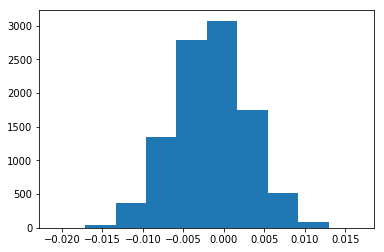

In [114]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [115]:
act_diff = df2.query('landing_page == "new_page"')['converted'].mean() - df2.query('landing_page == "old_page"')['converted'].mean()
act_diff

-0.0015782389853555567

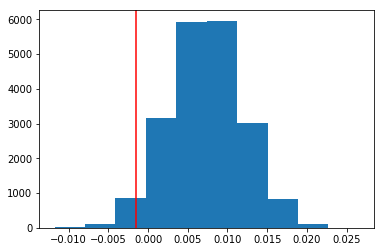

In [135]:
null_vals = np.random.normal(diff, p_diffs.std(), 20000);
plt.hist(null_vals);
plt.axvline(act_diff, color='red');

In [136]:
(null_vals > act_diff).mean()

0.97275

k. What is this value above called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value above is the p-value. The p-value of our simulated difference between the new and old page is at 0.9727. This means that 97.27% of the simulated observations are above the assumed difference under the null hypothesis. Thus, we fail to reject the null hypothesis with an alpha of 0.05. This means that we don't have enough evidence to deny that the old page is equal or even better than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. I will fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [120]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1')['user_id'].count()
convert_new = df2.query('landing_page == "new_page" & converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [138]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller', prop_var=0.05)

(1.951784263281866, 0.9745180882999716)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The first number above is the z-score that is 1.95, and the second one is the p-value of 0.9745. The z-score is supposed to be different than the assumed difference between the new and old page that is 0. However, we can see that the p-value is greater than our alpha at 0.05 for a 95% confidence interval. Thus, this results confirm our previous conclusion of rejecting the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

This type of problem could be translated into a logistic regression problem. Since the output can be conversion or no conversion.

b. The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [224]:
df2['intercept'] = 1
dummy = pd.get_dummies(df2['group'])
df2['ab_page'] = dummy['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [228]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [229]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:54:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The p-value associated with ab_page with respect to predicting conversion is 0.19. Although this p_value is not lower than 0.05 and thus we cannot say that the page used could determine conversion, but the p_value is much lower than that of the A/B test above. This is due to the fact that the null and alternative hypothesis in the logistic regression is **$P_{old}$** **$=$** **$P_{new}$** for the null, and **$P_{old}$** **$\neq$** **$P_{new}$** for the alternative.

In [273]:
1/np.exp(-0.015)

1.015113064615719

Even the coefficient would be translated to the following: If the user was given the new page, they are as likely to convert as if they recieved the olf page. 

f. Now, I want to consider other things that might influence whether or not an individual converts.  I want to discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into your regression model?

Since we only used one variable to determine whether a user converts or not and the correlation was not found. It is a good idea to add other potential identifiers to the model. The potential problem of doing so would be a multicollinearity problem, where correlation exists between the different variables; however, we can detect and solve such problem if need be.

g. Now along with testing if the conversion rate changes for different pages, also I will add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [276]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [277]:
### Create the necessary dummy variables
df_new['intercept'] = 1
dummy = pd.get_dummies(df_new['country'])
df_new[['UK', 'CA']] = dummy[['UK', 'CA']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


h. Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  I will create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [278]:
### Fit Your Linear Model And Obtain the Results
mod2 = sm.Logit(df_new['converted'], df_new[['intercept',  'UK', 'CA']])
results2 = mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 27 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        15:39:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [279]:
print(1/np.exp(0.0099))
print(1/np.exp(-0.0408))

0.9901488436829571
1.0416437559600236


As we can see with the above summary and statistics, the countries do not determine a statistical significance to determining whether a user would convert or not.